In [1]:
import torch
from datetime import datetime
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from src.kinematics import Kinematics, Vector3
import os

In [2]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self):
        self.items = []
        for c in range (-90,90,10):
            for f in range(-90,90,10):
                for t in range(-90,90,10):
                    x,y,z = Kinematics.forward(Vector3(c,f,t)).array()
                    self.items.append([round(x,2), round(y,2), round(z,2), c/90.0, f/90.0, t/90.0])

        self.items = np.array(self.items)
        X = self.items[:,0:3]
        Y = self.items[:,3:6]
        self.maxs = np.max(X,0)
        self.means = np.mean(X,0)
        self.stds = np.std(X,0)
        X = self.normalize(X, self.means, self.stds, self.maxs)
        self.inputs = torch.from_numpy(X.astype(np.float32))
        #self.inputs = torch.nn.functional.normalize(torch.from_numpy(X.astype(np.float32)),dim=0)
        self.targets = torch.from_numpy(Y.astype(np.float32))

        #X = (X-self.means)/self.stds
        #self.X = torch.nn.functional.normalize(input=torch.from_numpy(X.astype(np.float32)))
        # self.X = torch.from_numpy(X.astype(np.float32))
        # self.Y = torch.from_numpy(Y.astype(np.float32))

    @staticmethod
    def normalize(x, means, stds, maxs):
        return (x/np.max(maxs))
        #return (x-means)/stds

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):

        return self.inputs[idx].reshape(1,-1), self.targets[idx].reshape(1,-1)




In [3]:
dataset = Dataset()
test_percent = 0.2
num_test = int(test_percent * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - num_test, num_test])

train_loader = torch.utils.data.DataLoader(train_dataset,
                                     batch_size=100,
                                     shuffle=True,
                                     num_workers=0)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                     batch_size=100,
                                     shuffle=True,
                                     num_workers=0)

In [4]:
model = nn.Sequential(
    nn.Linear(3,16),
    nn.Linear(16,32),
    nn.Linear(32,64),
    nn.ReLU(),
    nn.Linear(64,3)
)

best_model = '/Users/kevywilly/Projects/vecna/best_model.pth'


In [5]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
epochs = 1500

In [6]:

# Stuff to store
train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs)
best_loss = 1e9
for it in range(epochs):
# zero the parameter gradients
    model.train()
    t0 = datetime.now()

    optimizer.zero_grad()
    train_loss = []

    for inputs, targets in iter(train_loader):
    # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        train_loss.append(loss.item())
        # Backward and optimize
        loss.backward()
        optimizer.step()

    train_loss = np.mean(train_loss)
    train_losses[it] = train_loss

    model.eval()
    test_loss = []
    for inputs, targets in iter(test_loader):
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss.append(loss.item())

    test_loss = np.mean(test_loss)
    test_losses[it] = test_loss

# Save losses
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')


    if test_loss < best_loss:
        #torch.save(model.state_dict(), best_model)
        best_loss = test_loss



Epoch 1/1500, Train Loss: 0.2824,       Test Loss: 0.2032, Duration: 0:00:00.038119
Epoch 2/1500, Train Loss: 0.1635,       Test Loss: 0.0970, Duration: 0:00:00.026576
Epoch 3/1500, Train Loss: 0.0862,       Test Loss: 0.0786, Duration: 0:00:00.026291
Epoch 4/1500, Train Loss: 0.0690,       Test Loss: 0.0582, Duration: 0:00:00.026167
Epoch 5/1500, Train Loss: 0.0530,       Test Loss: 0.0454, Duration: 0:00:00.026450
Epoch 6/1500, Train Loss: 0.0425,       Test Loss: 0.0411, Duration: 0:00:00.026136
Epoch 7/1500, Train Loss: 0.0396,       Test Loss: 0.0390, Duration: 0:00:00.026069
Epoch 8/1500, Train Loss: 0.0378,       Test Loss: 0.0374, Duration: 0:00:00.026623
Epoch 9/1500, Train Loss: 0.0378,       Test Loss: 0.0380, Duration: 0:00:00.027548
Epoch 10/1500, Train Loss: 0.0366,       Test Loss: 0.0366, Duration: 0:00:00.027212
Epoch 11/1500, Train Loss: 0.0367,       Test Loss: 0.0352, Duration: 0:00:00.026364
Epoch 12/1500, Train Loss: 0.0352,       Test Loss: 0.0348, Duration: 0:00

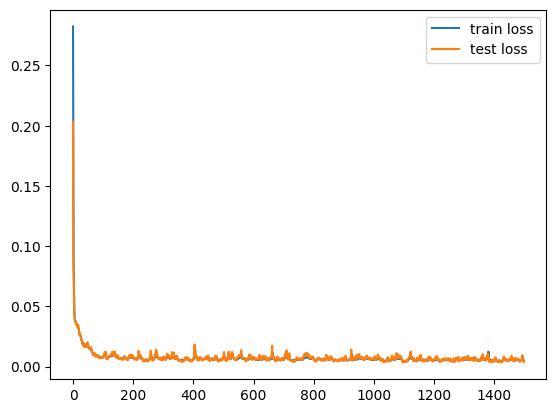

In [7]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()


In [8]:
model.eval()
sample = dataset[50]
output = model.forward(sample[0])
print(sample)
print(output)
print('predicted', output.detach().numpy()*90)
print('actual', sample[1].detach().numpy()*90)


(tensor([[-0.5298,  0.5298, -0.2528]]), tensor([[-1.0000, -0.7778,  0.5556]]))
tensor([[-1.0245, -0.7650,  0.5219]], grad_fn=<AddmmBackward0>)
predicted [[-92.20646  -68.8463    46.974804]]
actual [[-90.       -70.        50.000004]]


In [9]:
print(dataset.means, dataset.stds, dataset.maxs)

[-1.14875857 36.55266804 -2.22222222] [48.79383234 61.68878012 28.19638266] [126.1  148.71  39.39]


In [10]:
means = dataset.means
stds = dataset.stds
maxs = dataset.maxs
x = np.array([[0,65,0]])
x = Dataset.normalize(x,means,stds,maxs)
print(x)
input = torch.from_numpy(x.astype(np.float32))
output = model.forward(input).detach().numpy()*90
print(input)
print(np.floor(output))

[[0.         0.43709233 0.        ]]
tensor([[0.0000, 0.4371, 0.0000]])
[[0. 0. 0.]]


In [12]:
torch.save(model.state_dict(), '/Users/kevywilly/Projects/vecna/best_model.pth')